In [72]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [73]:
path = "BHSig260/Hindi/"

In [74]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

#dir_list=[x[0] for x in os.walk(path)]

In [75]:
dir_list

['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020']

In [76]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [77]:
orig_groups

[['BHSig260/Hindi/001/H-S-1-G-01.tif',
  'BHSig260/Hindi/001/H-S-1-G-02.tif',
  'BHSig260/Hindi/001/H-S-1-G-03.tif',
  'BHSig260/Hindi/001/H-S-1-G-04.tif',
  'BHSig260/Hindi/001/H-S-1-G-05.tif',
  'BHSig260/Hindi/001/H-S-1-G-06.tif',
  'BHSig260/Hindi/001/H-S-1-G-07.tif',
  'BHSig260/Hindi/001/H-S-1-G-08.tif',
  'BHSig260/Hindi/001/H-S-1-G-09.tif',
  'BHSig260/Hindi/001/H-S-1-G-10.tif',
  'BHSig260/Hindi/001/H-S-1-G-11.tif',
  'BHSig260/Hindi/001/H-S-1-G-12.tif',
  'BHSig260/Hindi/001/H-S-1-G-13.tif',
  'BHSig260/Hindi/001/H-S-1-G-14.tif',
  'BHSig260/Hindi/001/H-S-1-G-15.tif',
  'BHSig260/Hindi/001/H-S-1-G-16.tif',
  'BHSig260/Hindi/001/H-S-1-G-17.tif',
  'BHSig260/Hindi/001/H-S-1-G-18.tif',
  'BHSig260/Hindi/001/H-S-1-G-19.tif',
  'BHSig260/Hindi/001/H-S-1-G-20.tif',
  'BHSig260/Hindi/001/H-S-1-G-21.tif',
  'BHSig260/Hindi/001/H-S-1-G-22.tif',
  'BHSig260/Hindi/001/H-S-1-G-23.tif',
  'BHSig260/Hindi/001/H-S-1-G-24.tif'],
 ['BHSig260/Hindi/002/H-S-2-G-01.tif',
  'BHSig260/Hindi/002/H-

In [78]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(20, 20)

In [79]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [80]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [81]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


#### Train-Validation-Test Split
* Signatures of 120 people are used for training
* Signatures of 20 people are used for validation
* Signatures of 20 people are used for testing

In [82]:
orig_train, orig_val, orig_test = orig_groups[:10], orig_groups[10:15], orig_groups[15:]
forg_train, forg_val, forg_test = forg_groups[:10], forg_groups[10:15], forg_groups[15:]

In [83]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [84]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [85]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

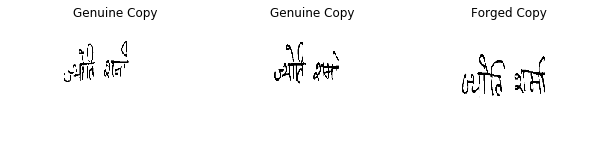

In [86]:
visualize_sample_signature()

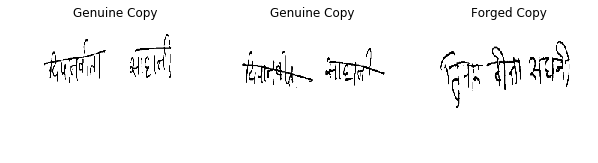

In [87]:
visualize_sample_signature()

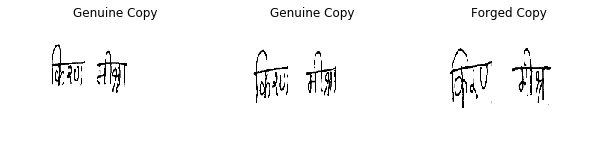

In [88]:
visualize_sample_signature()

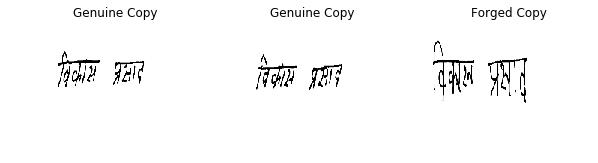

In [89]:
visualize_sample_signature()

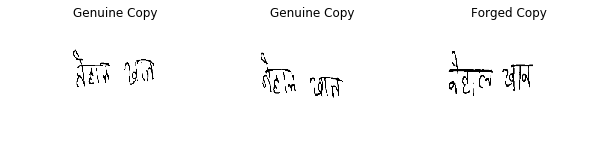

In [90]:
visualize_sample_signature()

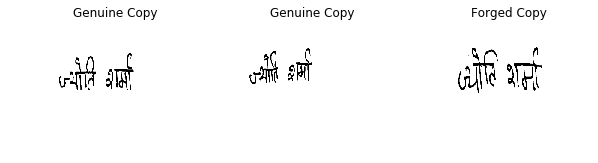

In [91]:
visualize_sample_signature()

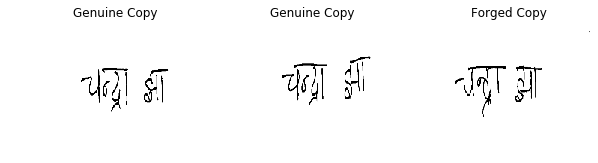

In [92]:
visualize_sample_signature()

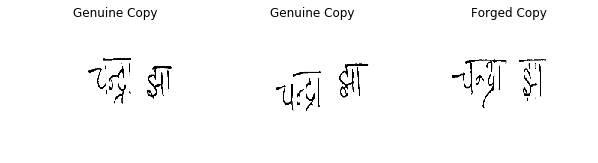

In [93]:
visualize_sample_signature()

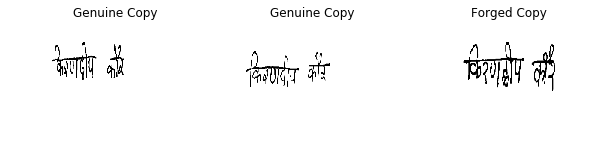

In [94]:
visualize_sample_signature()

In [95]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [96]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [97]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [98]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [106]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq

In [107]:
input_shape=(img_h, img_w, 1)

In [113]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

C:\Users\Saurav\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, kernel_size=(11, 11), activation="relu", name="conv1_1", strides=4, input_shape=(155, 220,..., data_format="channels_last", kernel_initializer="glorot_uniform")`
  
C:\Users\Saurav\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)`
  import sys
C:\Users\Saurav\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((2, 2), data_format="channels_last")`
  if __name__ == '__main__':
C:\Users\Saurav\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(5, 5), activation="relu", name="conv2_1", stride

In [114]:
batch_sz = 128
num_train_samples = 276*10 + 300*10
num_val_samples = num_test_samples = 276*5 + 300*5
num_train_samples, num_val_samples, num_test_samples

(5760, 2880, 2880)

In [115]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [116]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('Weights/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [117]:
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/100
45/45 [==============================] - 1886s 42s/step - loss: 7.4180 - val_loss: 1.3946

Epoch 00001: saving model to Weights/signet-bhsig260-001.h5
Epoch 2/100
45/45 [==============================] - 1874s 42s/step - loss: 1.1660 - val_loss: 1.3669

Epoch 00002: saving model to Weights/signet-bhsig260-002.h5
Epoch 3/100
45/45 [==============================] - 1841s 41s/step - loss: 1.1431 - val_loss: 1.3166

Epoch 00003: saving model to Weights/signet-bhsig260-003.h5
Epoch 4/100
45/45 [==============================] - 1849s 41s/step - loss: 1.0137 - val_loss: 1.1713

Epoch 00004: saving model to Weights/signet-bhsig260-004.h5
Epoch 5/100
45/45 [==============================] - 1842s 41s/step - loss: 0.8716 - val_loss: 1.0192

Epoch 00005: saving model to Weights/signet-bhsig260-005.h5
Epoch 6/100
45/45 [==============================] - 1844s 41s/step - loss: 0.7268 - val_loss: 0.9015

Epoch 00006: saving model to Weights/signet-bhsig260-006.h5
Epoch 7/100
45/45 [===

C:\Users\Saurav\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Saurav\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:1090: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)



Epoch 00014: saving model to Weights/signet-bhsig260-014.h5
Epoch 15/100
45/45 [==============================] - 3622s 80s/step - loss: nan - val_loss: nan

Epoch 00015: saving model to Weights/signet-bhsig260-015.h5
Epoch 16/100
45/45 [==============================] - 3629s 81s/step - loss: nan - val_loss: nan

Epoch 00016: saving model to Weights/signet-bhsig260-016.h5
Epoch 17/100
35/45 [======================>.......] - ETA: 11:06 - loss: nan

KeyboardInterrupt: 

#### After observing continuous fall in validation accuracy, I interrupted the training manually

In [118]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [119]:
model.load_weights('Weights/signet-bhsig260-013.h5')

In [120]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [121]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.77208407078792, 0.43)

#### Accuracy = 81.71% and Threshold = 0.55
Thus if the differnce score is less than 0.55, we predict the test image as Genuine and if the difference score is greater than 0.55, we predict it to be as forged

#### Below we see some sample results

In [122]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

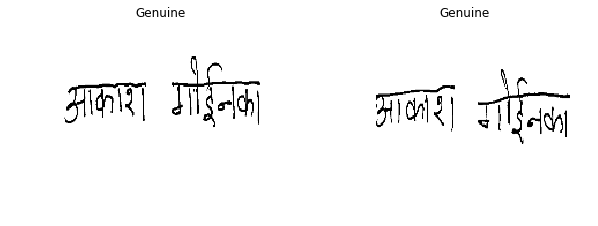

Difference Score =  0.07600404
Its a Genuine Signature


In [123]:
predict_score()

### Note: The first image is always Genuine. Score prediction and classification is done for the second image

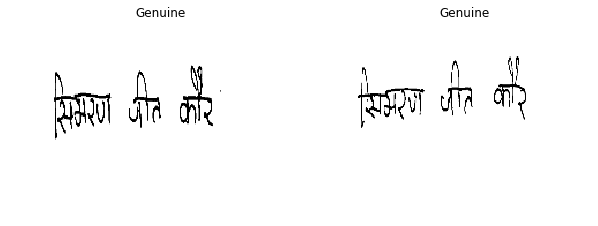

Difference Score =  0.46045497
Its a Forged Signature


In [124]:
predict_score()

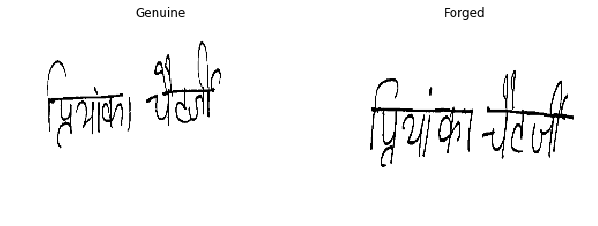

Difference Score =  0.24524602
Its a Genuine Signature


In [125]:
predict_score()

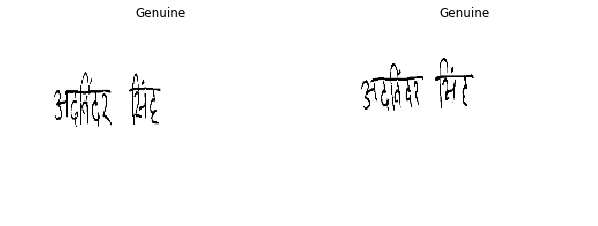

Difference Score =  0.0
Its a Genuine Signature


In [126]:
predict_score()

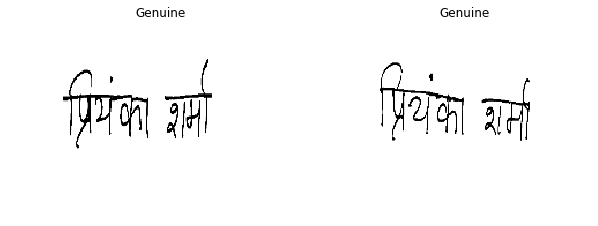

Difference Score =  0.21442367
Its a Genuine Signature


In [127]:
predict_score()

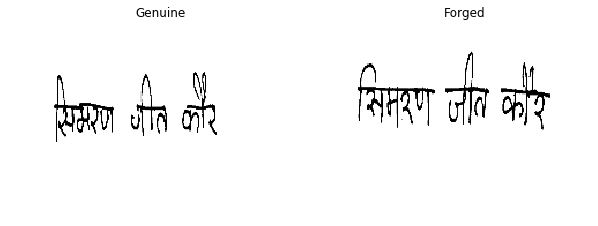

Difference Score =  0.09245439
Its a Genuine Signature


In [128]:
predict_score()

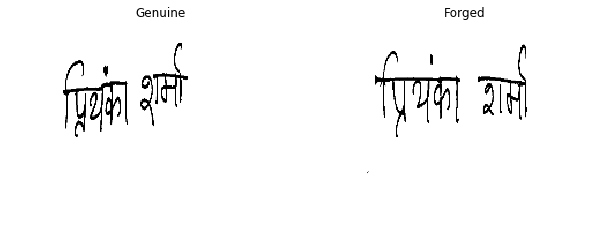

Difference Score =  0.4808447
Its a Forged Signature


In [129]:
predict_score()

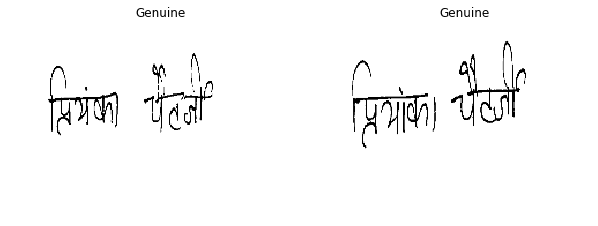

Difference Score =  0.73272014
Its a Forged Signature


In [130]:
predict_score()

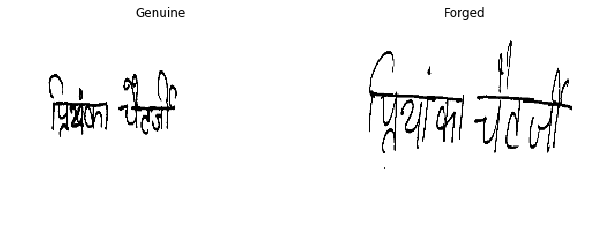

Difference Score =  1.4465986
Its a Forged Signature


In [131]:
predict_score()

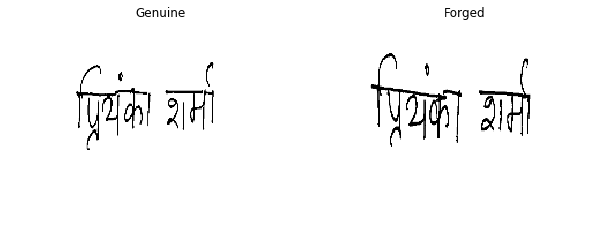

Difference Score =  0.57554555
Its a Forged Signature


In [132]:
predict_score()

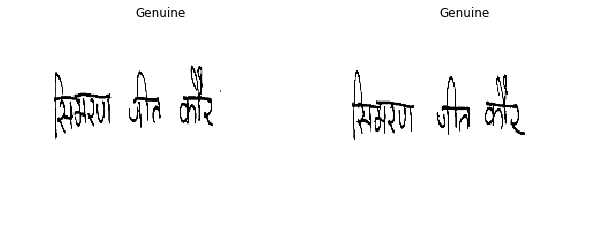

Difference Score =  0.20292579
Its a Genuine Signature


In [133]:
predict_score()

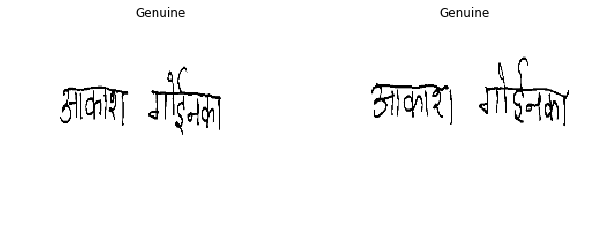

Difference Score =  0.0076663643
Its a Genuine Signature


In [134]:
predict_score()

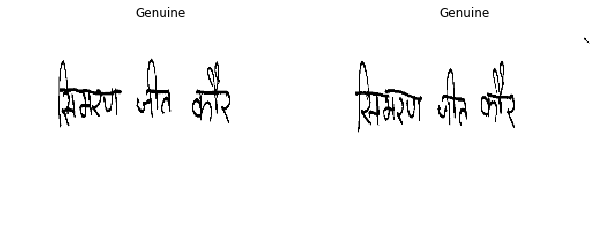

Difference Score =  0.09745232
Its a Genuine Signature


In [135]:
predict_score()

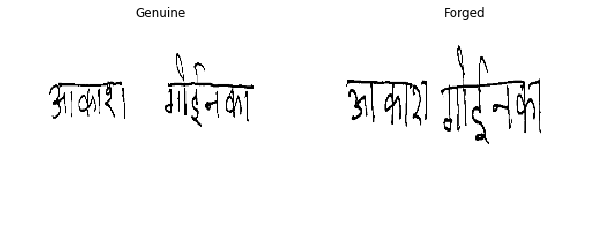

Difference Score =  0.9193303
Its a Forged Signature


In [136]:
predict_score()

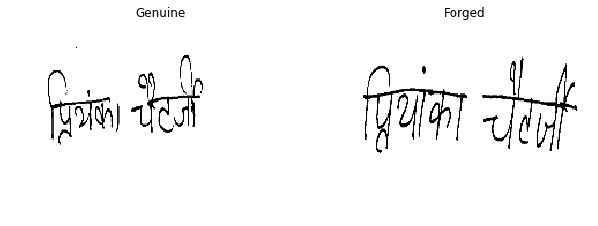

Difference Score =  0.63886875
Its a Forged Signature


In [137]:
predict_score()

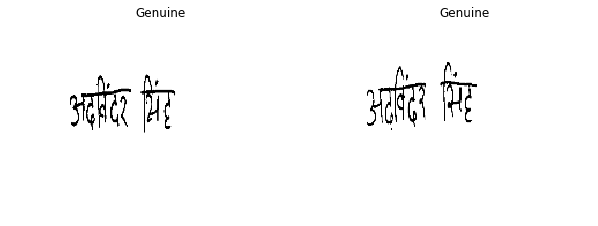

Difference Score =  0.0
Its a Genuine Signature


In [138]:
predict_score()

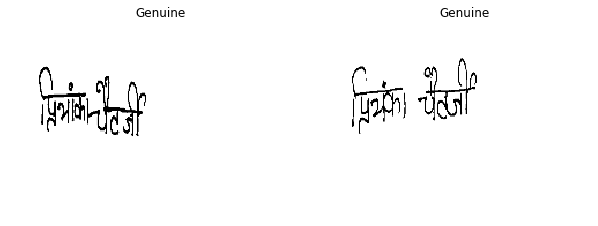

Difference Score =  0.3012906
Its a Genuine Signature


In [139]:
predict_score()

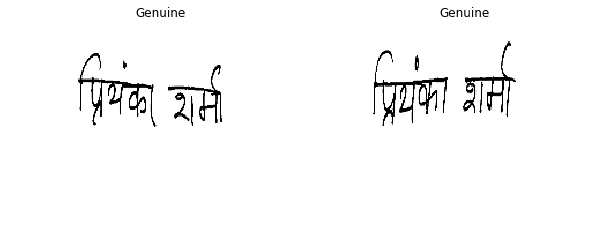

Difference Score =  0.15903933
Its a Genuine Signature


In [140]:
predict_score()

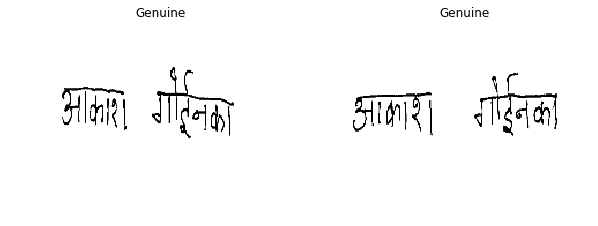

Difference Score =  0.030017074
Its a Genuine Signature


In [141]:
predict_score()

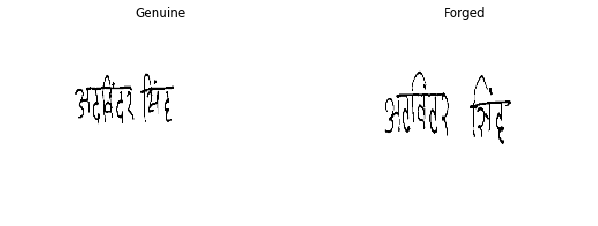

Difference Score =  0.33815068
Its a Genuine Signature


In [142]:
predict_score()

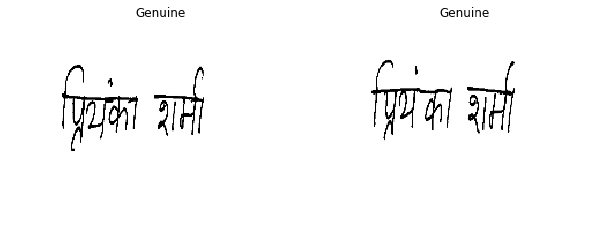

Difference Score =  0.10105418
Its a Genuine Signature


In [143]:
predict_score()

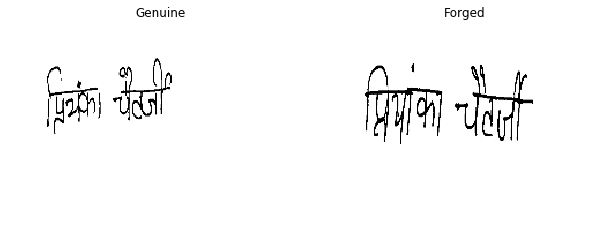

Difference Score =  1.1331625
Its a Forged Signature


In [144]:
predict_score()

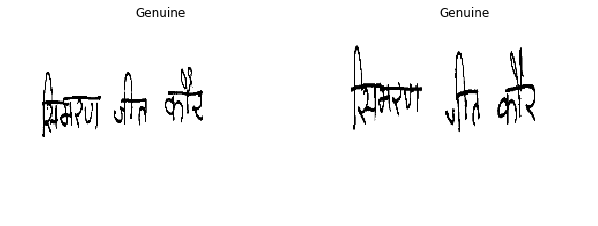

Difference Score =  0.5335502
Its a Forged Signature


In [145]:
predict_score()

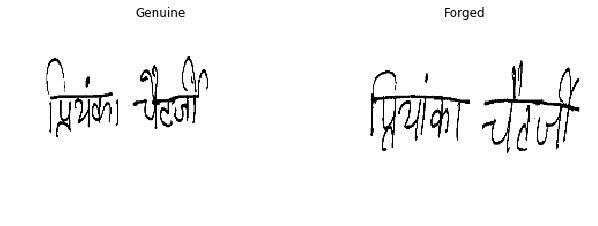

Difference Score =  0.22259279
Its a Genuine Signature


In [146]:
predict_score()

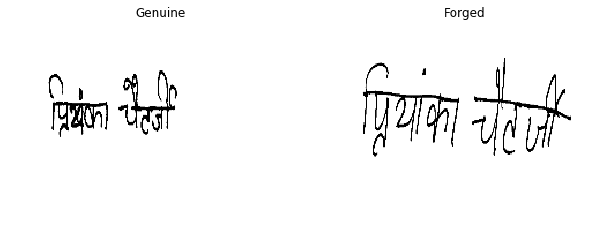

Difference Score =  1.1722746
Its a Forged Signature


In [147]:
predict_score()

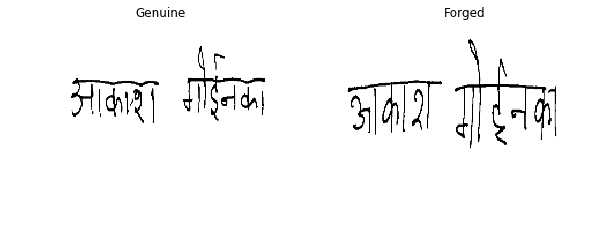

Difference Score =  1.1022366
Its a Forged Signature


In [148]:
predict_score()

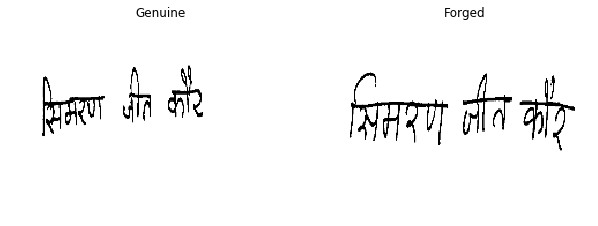

Difference Score =  0.6521759
Its a Forged Signature


In [149]:
predict_score()

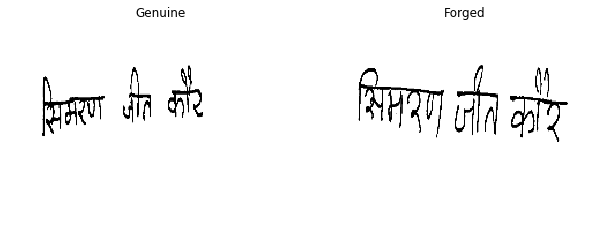

Difference Score =  0.3201779
Its a Genuine Signature


In [150]:
predict_score()

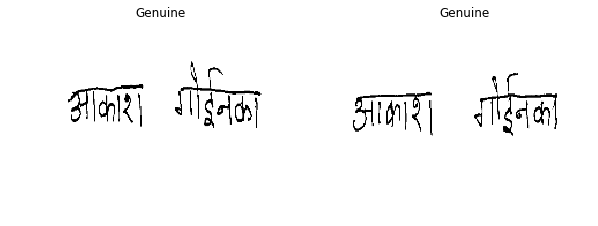

Difference Score =  0.10688025
Its a Genuine Signature


In [151]:
predict_score()

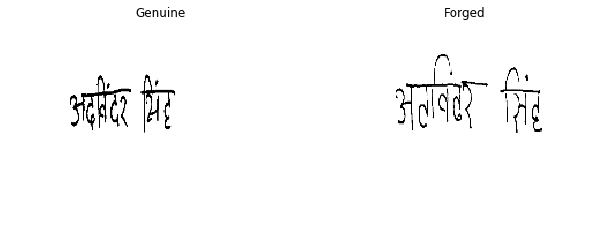

Difference Score =  0.46796215
Its a Forged Signature


In [152]:
predict_score()

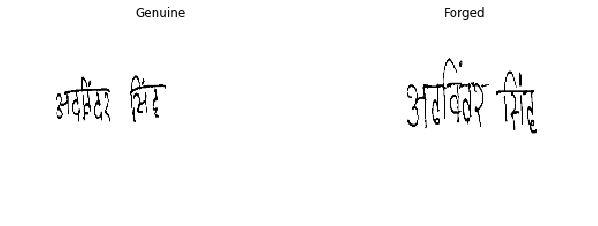

Difference Score =  0.46893308
Its a Forged Signature


In [153]:
predict_score()

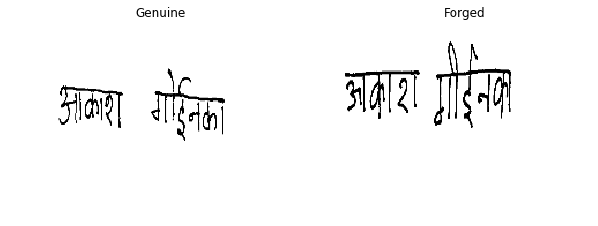

Difference Score =  0.8596925
Its a Forged Signature


In [154]:
predict_score()

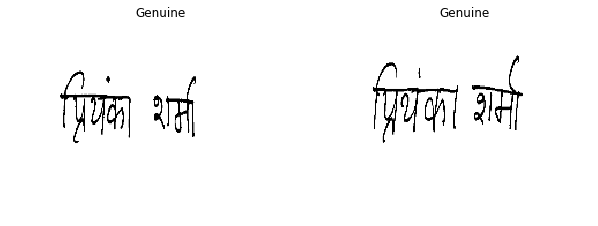

Difference Score =  0.58663875
Its a Forged Signature


In [155]:
predict_score()

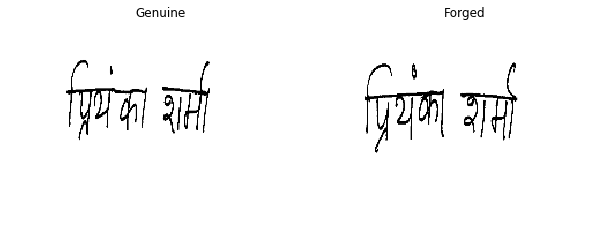

Difference Score =  0.15172109
Its a Genuine Signature


In [156]:
predict_score()

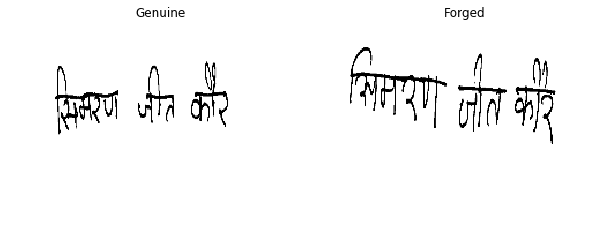

Difference Score =  0.8565907
Its a Forged Signature


In [157]:
predict_score()

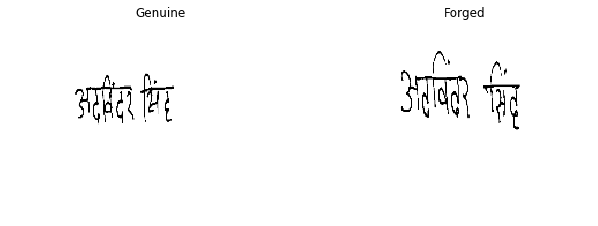

Difference Score =  0.21454974
Its a Genuine Signature


In [158]:
predict_score()

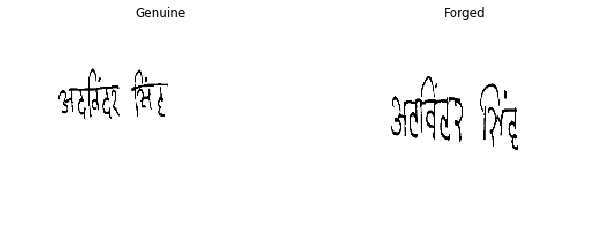

Difference Score =  0.71582866
Its a Forged Signature


In [159]:
predict_score()

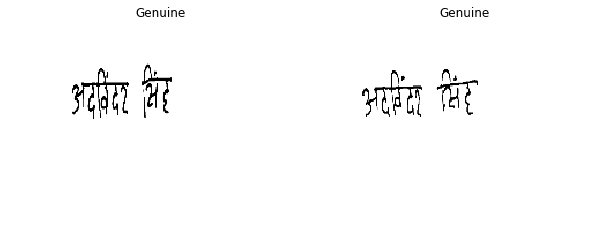

Difference Score =  0.0
Its a Genuine Signature


In [160]:
predict_score()

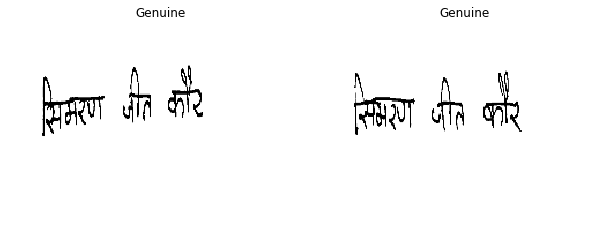

Difference Score =  0.22760281
Its a Genuine Signature


In [161]:
predict_score()

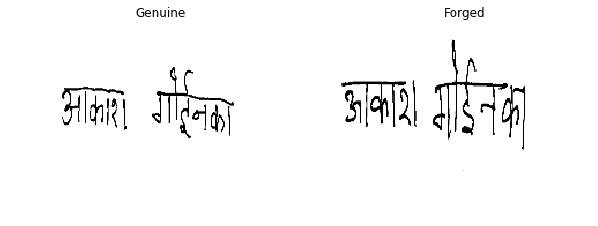

Difference Score =  1.0461648
Its a Forged Signature


In [162]:
predict_score()

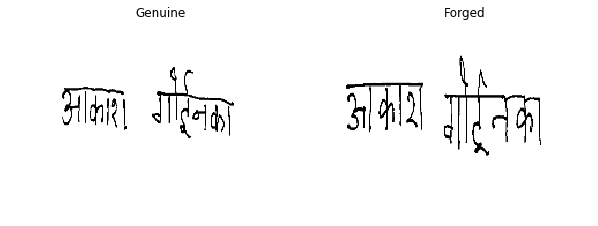

Difference Score =  0.87067676
Its a Forged Signature


In [163]:
predict_score()

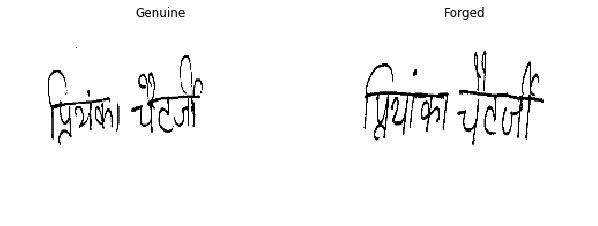

Difference Score =  0.59328026
Its a Forged Signature


In [164]:
predict_score()

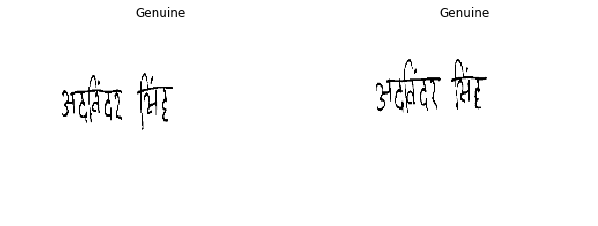

Difference Score =  0.0
Its a Genuine Signature


In [165]:
predict_score()

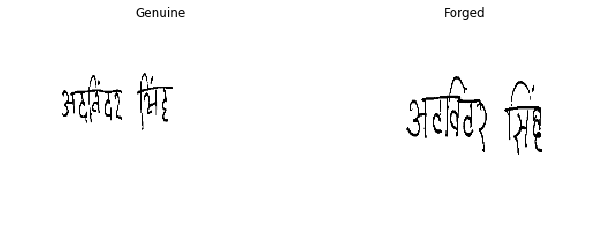

Difference Score =  0.78555685
Its a Forged Signature


In [166]:
predict_score()

In [168]:
def pred_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    #ax1.imshow(np.squeeze(img1), cmap='gray')
    #ax2.imshow(np.squeeze(img2), cmap='gray')
    #ax1.set_title('Genuine')
    #if test_label == 1:
     #   ax2.set_title('Genuine')
    #else:
    #    ax2.set_title('Forged')
    #ax1.axis('off')
    #ax2.axis('off')
    #plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        return 0
    else:
        return 1

In [173]:
from sklearn import metrics
import seaborn as sns

In [167]:
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [169]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    diff=model.predict([img1,img2])[0][0]
    if diff > threshold:
        pred.append(0)
    else:
        pred.append(1)

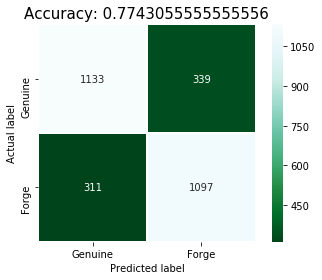

In [174]:
pretty_cm(pred, tr_y, ['Genuine', 'Forge'])